# Experiment 1: All metrics / Default parameters / Synthetic data

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [2]:
project_root_path = os.path.join('..', '..')
experiment_path = os.path.join(project_root_path, 'experiments', 'allmetrics_defparams_syn')
results_path = os.path.join(experiment_path, 'results')

save_fig_path = os.path.join(experiment_path, 'figures')
os.makedirs(save_fig_path, exist_ok=True)

In [3]:
def load_results(csv_file):
    return pd.read_csv(csv_file, index_col=0)

result_files = [file for file in os.listdir(results_path) if file.endswith('.csv')]
print(f'Number of result files: {len(result_files)}')

Number of result files: 70


In [4]:
formal_names = {
    'FF-VUS': 'FF-VUS (L: 128)',
    'FF-VUS-GPU': 'FF-VUS-GPU (L: 128)',
    'AUC': 'AUC',
    'VUS': 'VUS (L: 128)',
    'RF': 'RF',
    'AFFILIATION': 'AFFILIATION',
    'RANGE-AUC': 'Range-AUC (L: 128)',
}

color_palette = {
    'FF-VUS (L: 128)': '#eee13f',          # Good
    'FF-VUS-GPU (L: 128)': '#40da70',     # Very Good
    'AUC': '#f1a73f',                # Secondary competitor
    'VUS (L: 128)': '#b02a41',            # Main competitor
    'AFFILIATION': '#A5D1C2',        # Useless competitors
    'Range-AUC (L: 128)': '#547C6E',       # Useless competitors
    'RF': '#123327',                    # Useless competitors
}

In [5]:
# Initialize an empty DataFrame to store the combined data
df = pd.DataFrame()

# Read and combine all files
for file in tqdm(result_files):
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path, index_col=0).reset_index()
    df = pd.concat([df, curr_df], ignore_index=True)

df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████████████████████████████████████| 70/70 [00:00<00:00, 385.65it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Metric,Metric value,Metric time,Slope size,Step,Global mask,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
2742,syn_len_100000_n_10_avglen_200.npz,100000,10,197.800000,Range-AUC (L: 128),0.984208,0.144607,128.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,syn_len_100000_n_20_avglen_10.npz,100000,20,10.000000,AFFILIATION,0.989536,0.040674,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2717,syn_len_100000_n_900_avglen_10.npz,100000,820,10.529268,VUS (L: 128),0.992826,44.843527,128.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analysis

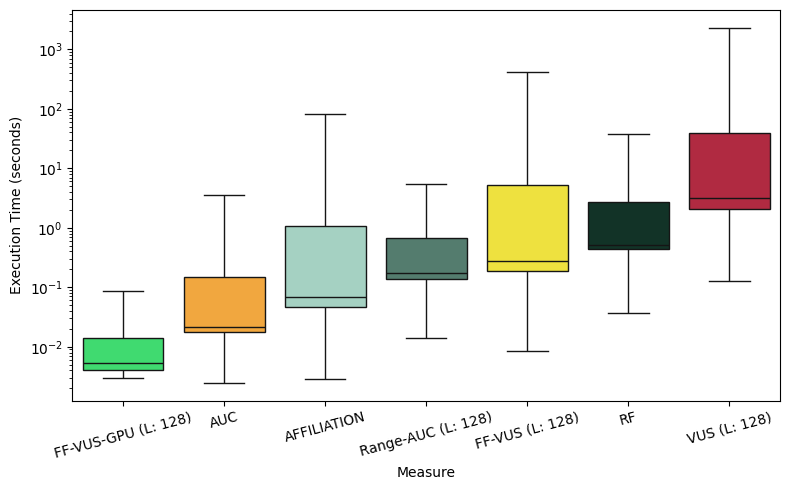

In [6]:
# TODO: Find why there is this big lines per metric, what affects this

# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(8, 5))
sns.boxplot(
    y='Metric time', 
    x='Metric', 
    hue='Metric', 
    data=df, 
    showfliers=False, 
    log_scale=True, 
    palette=color_palette, 
    order=order, 
    saturation=1,
    # showmeans=True, 
    # meanline=True
)
plt.xlabel('Measure')
plt.ylabel('Execution Time (seconds)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_comparison.svg'))
plt.show()

In [25]:
length_analysis_df = df[df['Length'] != 100_000]
n_anomalies_analysis_df = df[np.logical_and(df['Time series'].str.contains('len_100000_'), df['Time series'].str.contains('_avglen_10.npz'))]
avg_anomaly_length_analysis_df = df[df['Time series'].str.contains('len_100000_n_10_')]

In [7]:
# def filter_within_tolerance(df, expected_values, tolerance=0.25):
#     """
#     Filter rows where any characteristic deviates by more than `tolerance` from the expected value.
#     """
#     for col, expected in expected_values.items():
#         lower_bound = expected * (1 - tolerance)
#         upper_bound = expected * (1 + tolerance)
#         df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
#     return df

# # Length Analysis: Expected values
# length_expected = {'Number of anomalies': 10, 'Anomalies average length': 100}
# length_analysis_df = df[df['Time series'].str.contains('n_10_avglen_100')]
# length_analysis_df = filter_within_tolerance(length_analysis_df, length_expected)

# # Number of Anomalies Analysis: Expected values
# n_anomalies_expected = {'Length': 100000, 'Anomalies average length': 100}
# n_anomalies_analysis_df = df[df['Time series'].str.contains('len_100000_') & df['Time series'].str.contains('_avglen_100')]
# n_anomalies_analysis_df = filter_within_tolerance(n_anomalies_analysis_df, n_anomalies_expected)

# # Average Anomaly Length Analysis: Expected values
# avg_anomaly_length_expected = {'Length': 100000, 'Number of anomalies': 10}
# avg_anomaly_length_analysis_df = df[df['Time series'].str.contains('len_100000_n_10_')]
# avg_anomaly_length_analysis_df = filter_within_tolerance(avg_anomaly_length_analysis_df, avg_anomaly_length_expected)


--- Length Analysis ---
Total number of time series: 190
Total number of points: 42949591040, 42949591k, 42949m, 42b
Length -> min: 8192, max: 2147483648
Number of anomalies -> min: 9, max: 10
Anomalies average length -> min: 9.9, max: 11.0


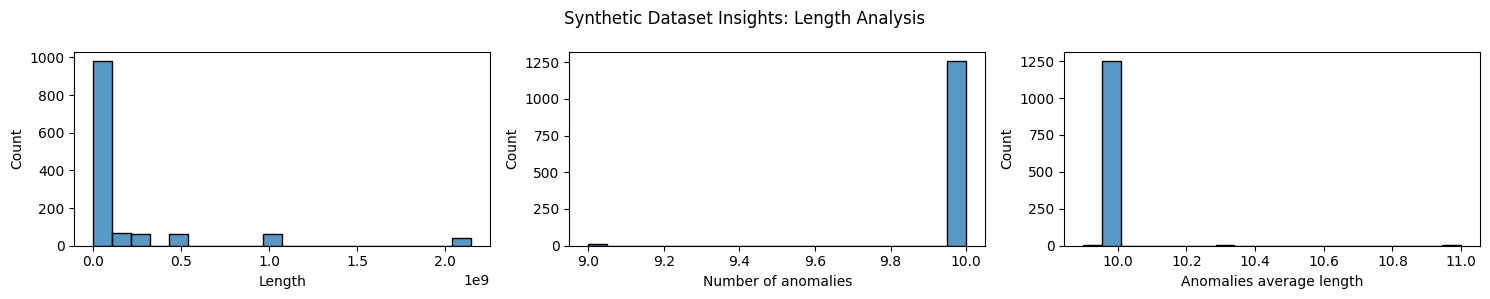


--- Number of Anomalies Analysis ---
Total number of time series: 150
Total number of points: 15000000, 15000k, 15m, 0b
Length -> min: 100000, max: 100000
Number of anomalies -> min: 1, max: 920
Anomalies average length -> min: 10.0, max: 10.590628853267573


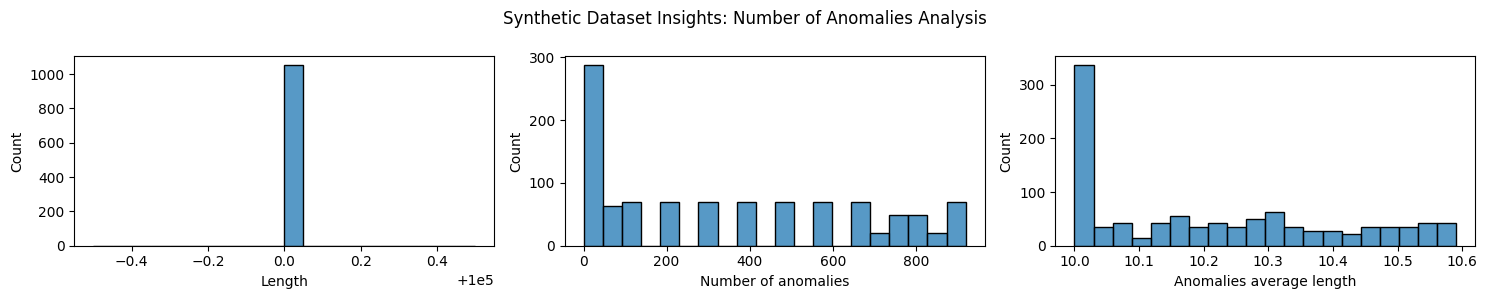


--- Average Anomaly Length Analysis ---
Total number of time series: 150
Total number of points: 15000000, 15000k, 15m, 0b
Length -> min: 100000, max: 100000
Number of anomalies -> min: 9, max: 10
Anomalies average length -> min: 1.0, max: 1050.888888888889


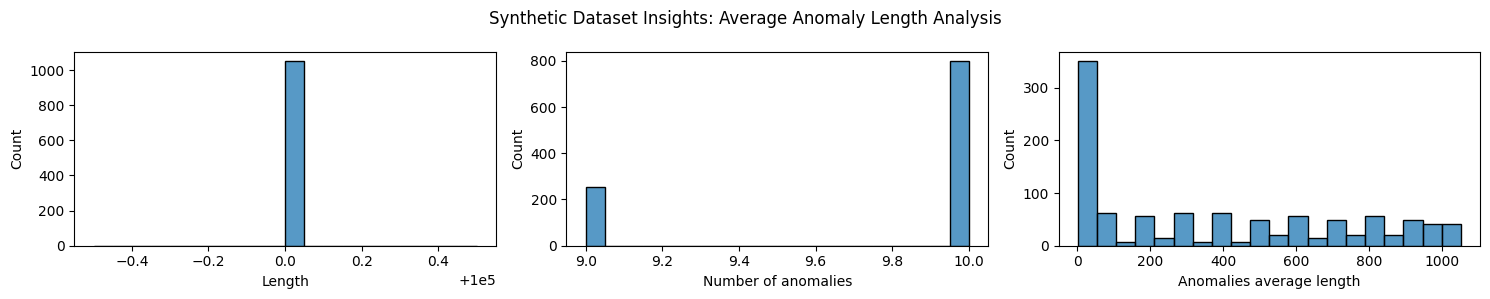

In [45]:
def plot_synthetic_insights(curr_df, group_name):
    """Plot synthetic dataset insights for a specific group."""
    print(f"\n--- {group_name} ---")
    metrics = curr_df['Metric'].unique()
    single_metric_df = curr_df[curr_df['Metric'] == metrics[0]]
    print(f"Total number of time series: {len(single_metric_df)}")
    print(f"Total number of points: {single_metric_df['Length'].sum()}, {single_metric_df['Length'].sum()//10**3}k, {single_metric_df['Length'].sum()//10**6}m, {single_metric_df['Length'].sum()//10**9}b")

    attributes = ["Length", "Number of anomalies", "Anomalies average length"]
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    bins = 20

    for attr, axis in zip(attributes, ax):
        print(f"{attr} -> min: {curr_df[attr].min()}, max: {curr_df[attr].max()}")
        sns.histplot(x=attr, data=curr_df, ax=axis, bins=bins)
        axis.set_xlabel(attr)

    plt.suptitle(f"Synthetic Dataset Insights: {group_name}")
    plt.tight_layout()
    plt.show()

plot_synthetic_insights(length_analysis_df, "Length Analysis")
plot_synthetic_insights(n_anomalies_analysis_df, "Number of Anomalies Analysis")
plot_synthetic_insights(avg_anomaly_length_analysis_df, "Average Anomaly Length Analysis")

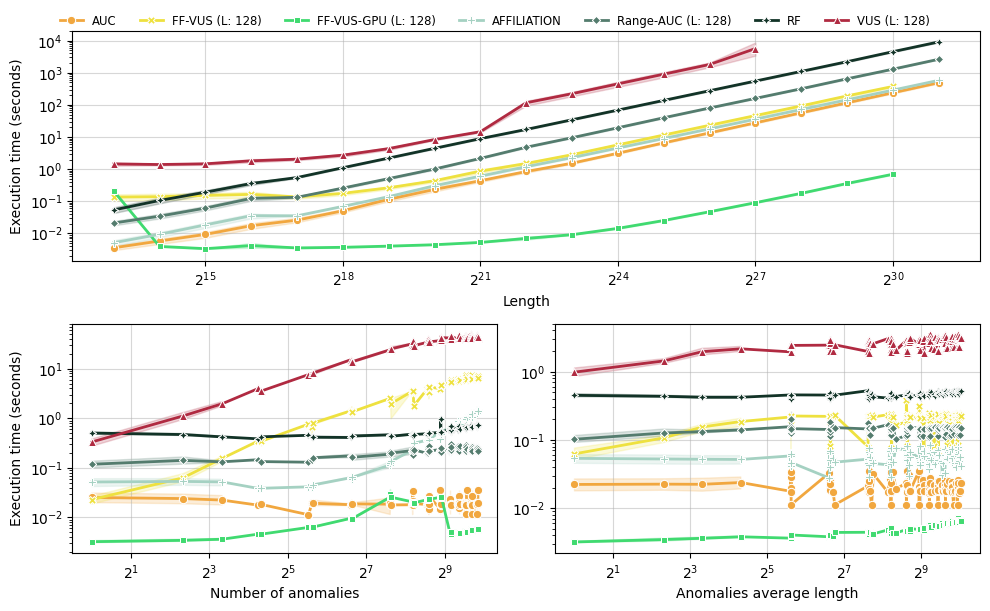

In [46]:
# TODO: Marker size increase
bins = 20
attr_control = {}
legend_axis = None
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
analysis_dfs = [length_analysis_df, n_anomalies_analysis_df, avg_anomaly_length_analysis_df]

attr_axis = {
    "Length": (2, 1, 1), 
    "Number of anomalies": (2, 2, 3), 
    "Anomalies average length": (2, 2, 4),
}
fig = plt.figure(figsize=(10, 6))
for i, attribute in enumerate(attributes):
    axis = fig.add_subplot(*attr_axis[attribute])
    curr_df = analysis_dfs[i]
    
    # Plot
    sns.lineplot(
        x=attribute,
        y='Metric time',
        hue='Metric',
        data=curr_df,
        ax=axis,
        palette=color_palette,
        markers=True,
        style='Metric',
        dashes = False,
        linewidth=2,
        # size='Metric', 
        # size_order=['FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'AFFILIATION', 'VUS (L: 128)', 'Range-AUC (L: 128)', 'RF', 'AUC']
    )

    axis.set_xlabel(attribute)
    axis.set_ylabel("Execution time (seconds)" if i != 2 else "")
    axis.set_yscale('log')
    axis.set_xscale('log', base=2)
    axis.grid(axis='both', alpha=0.5)
    if i != 0: 
        axis.get_legend().remove()
    else:
        legend_axis = axis


handles, labels = legend_axis.get_legend_handles_labels()
legend_axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_per_attr.svg'))
plt.show()